In [ ]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np

###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study1.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
outputdir = os.path.join(topdir, f'Analysis/{study}')

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accomodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accommodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accommodate['task'] = 'accommodate'
df_predict['task']   = 'predict'



print("Accomodate columns:", df_accommodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'shape_high', 'shape_low', 'tail_high', 'tail_low', 'shape_discrete_slider.response', 'shape_direction_slider.response', 'shape_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categorie

In [ ]:
df_accommodate['free_texts'] = df_accommodate['free_texts'].apply(ast.literal_eval)

<class 'list'>


In [23]:
print(df_accommodate['irrelevant_dim'])

0      shape
1      shape
2      color
3      color
4      shape
       ...  
145    color
146    color
147    color
148    shape
149     tail
Name: irrelevant_dim, Length: 150, dtype: object


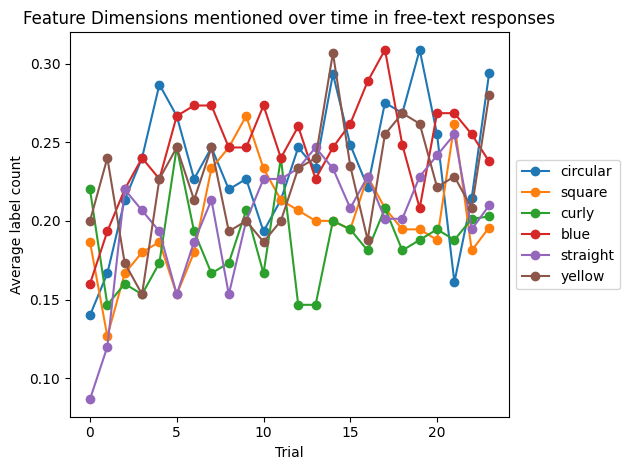

In [33]:
def count_labels_over_time(free_text_list, word_labels):
    """
    free_text_list: list of free-text responses (strings) in order
    word_labels: dict mapping label -> list of words
    Returns a list of dicts (one per trial) with counts per label
    """
    counts_over_time = []

    for text in free_text_list:
        text_lower = text.lower()  # lowercase 
        counts = {label: 0 for label in word_labels}

        for label, words in word_labels.items():
            for word in words:
                counts[label] += text_lower.count(word)  # count occurrences
        counts_over_time.append(counts)

    return counts_over_time


word_labels = {
    'circular': ['circle', 'circular', 'oval', 'round'],
    'square': ['square', 'squared', 'rectangle', 'rectangular'],
    'curly': ['curly'],
    'straight': ['straight'],
    'blue': ['blue'],
    'yellow': ['yellow']
}

all_counts = []

for idx, row in df_accommodate.iterrows():
    participant_id = row['participant'] 
    free_text_list = row['free_texts']
    
    counts = count_labels_over_time(free_text_list, word_labels)
    
    # Add participant ID and timepoint
    for trial, count_dict in enumerate(counts):
        count_dict.update({'participant': participant_id, 'trial': trial})
        all_counts.append(count_dict)

# Convert to DataFrame for analysis
df_counts = pd.DataFrame(all_counts)
df_grouped = df_counts.groupby('trial')[['circular','square','curly', 'blue', 'straight', 'yellow']].mean()
df_grouped.plot(marker='o')
plt.xlabel('Trial')
plt.ylabel('Average label count')
plt.title('Feature Dimensions mentioned over time in free-text responses')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout() 
plt.show()
plt.show()


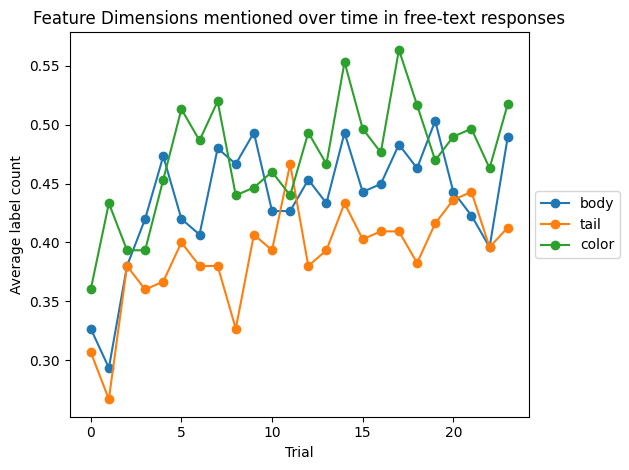

In [35]:
word_labels = {
    'body': ['circle', 'circular', 'oval', 'round', 'square', 'squared', 'rectangle', 'rectangular'],
    'tail': ['curly', 'straight'],
    'color': ['blue', 'yellow']
}

all_counts = []

for idx, row in df_accommodate.iterrows():
    participant_id = row['participant'] 
    free_text_list = row['free_texts']
    
    counts = count_labels_over_time(free_text_list, word_labels)
    
    # Add participant ID and timepoint
    for trial, count_dict in enumerate(counts):
        count_dict.update({'participant': participant_id, 'trial': trial})
        all_counts.append(count_dict)

# Convert to DataFrame for analysis
df_counts = pd.DataFrame(all_counts)
df_grouped = df_counts.groupby('trial')[['body', 'tail', 'color']].mean()
df_grouped.plot(marker='o')
plt.xlabel('Trial')
plt.ylabel('Average label count')
plt.title('Feature Dimensions mentioned over time in free-text responses')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout() 
plt.show()
plt.show()

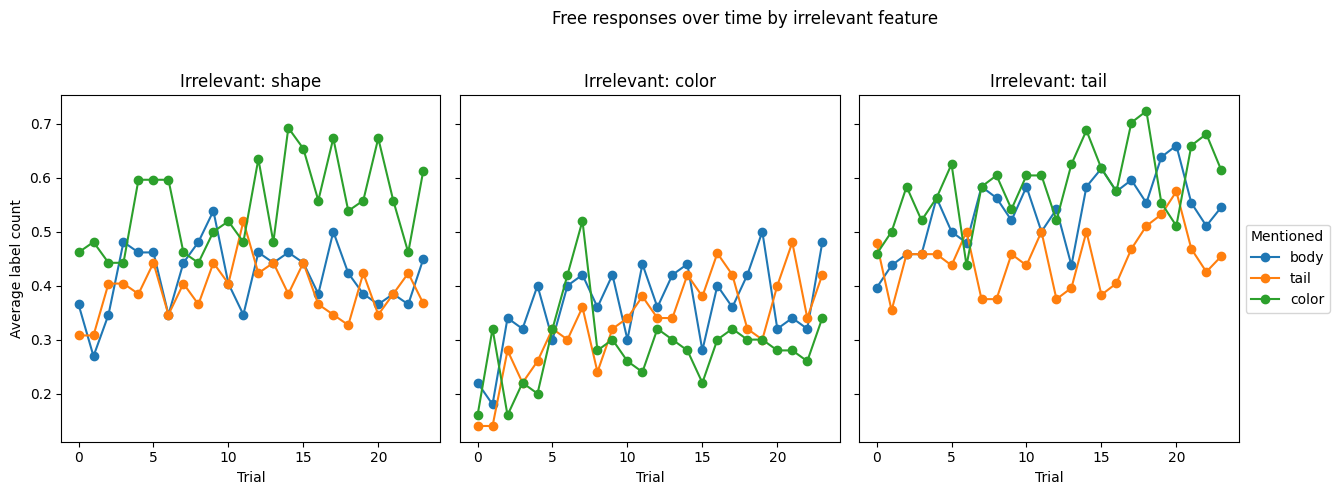

In [ ]:
def analyze_free_text_labels(df, word_labels, task_name='accommodate'):
    """
    df: DataFrame with columns ['participant', 'free_texts', 'irrelevant_dim']
    word_labels: dict mapping label -> list of words
    task_name: just for plot titles
    """
    all_counts = []

    for idx, row in df.iterrows():
        participant_id = row['participant']
        free_text_list = row['free_texts']
        irrelevant_feature = row['irrelevant_dim']

        counts = count_labels_over_time(free_text_list, word_labels)
        
        # Add participant ID, trial, and irrelevant_dim
        for trial, count_dict in enumerate(counts):
            count_dict.update({
                'participant': participant_id,
                'trial': trial,
                'irrelevant_dim': irrelevant_feature
            })
            all_counts.append(count_dict)

    # Convert to DataFrame
    df_counts = pd.DataFrame(all_counts)

    # Plot per irrelevant feature
    labels = list(word_labels.keys())
    irr_feats = df_counts['irrelevant_dim'].unique()
    fig, axes = plt.subplots(1, len(irr_feats), figsize=(15,5), sharey=True)

    for ax, irr_feat in zip(axes, irr_feats):
        df_grouped = df_counts[df_counts['irrelevant_dim'] == irr_feat] \
                        .groupby('trial')[labels].mean()
        df_grouped.plot(ax=ax, marker='o', legend=False)
        ax.set_title(f'Irrelevant: {irr_feat}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Average label count')

    plt.suptitle('Free responses over time by irrelevant feature')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Mentioned')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for suptitle
    plt.show()

    return df_counts
df_counts = analyze_free_text_labels(df_accommodate, word_labels)


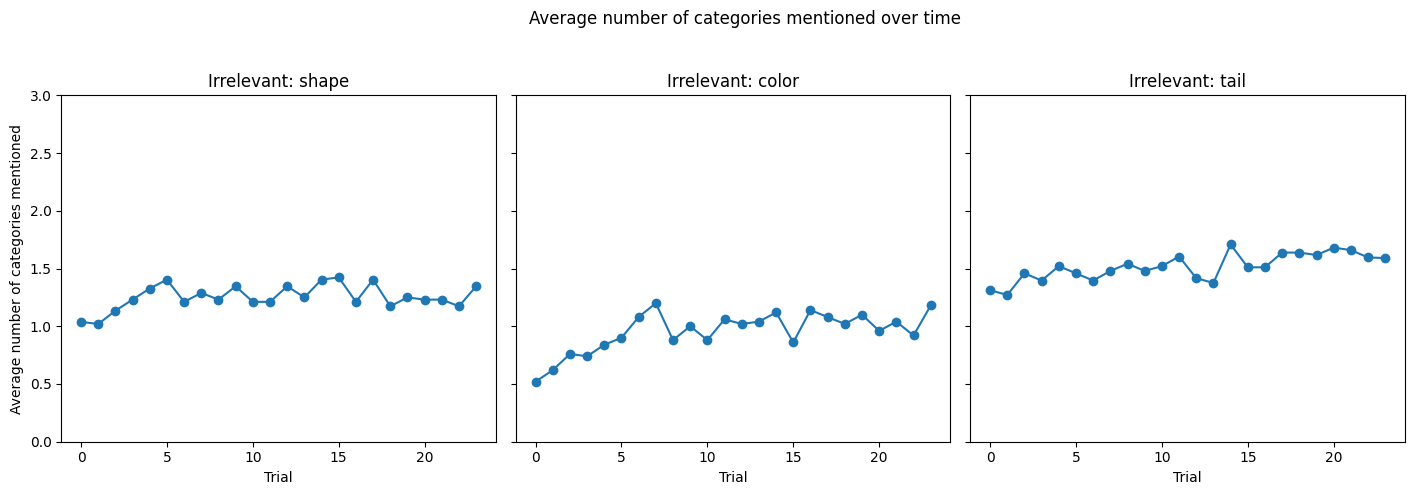

In [36]:
def analyze_free_text_num_mentions(df, word_labels, task_name='accommodate'):
    """
    df: DataFrame with columns ['participant', 'free_texts', 'irrelevant_dim']
    word_labels: dict mapping label -> list of words
    Returns: df_counts with number of categories mentioned per trial and plots 0-3 mentions over time
    """
    all_counts = []

    for idx, row in df.iterrows():
        participant_id = row['participant']
        free_text_list = row['free_texts']
        irrelevant_feature = row['irrelevant_dim']

        counts = count_labels_over_time(free_text_list, word_labels)
        
        # Convert counts into number of categories mentioned (0-3)
        for trial, count_dict in enumerate(counts):
            num_mentions = sum([1 for lbl in word_labels if count_dict[lbl] > 0])
            all_counts.append({
                'participant': participant_id,
                'trial': trial,
                'irrelevant_dim': irrelevant_feature,
                'num_mentions': num_mentions
            })

    df_counts = pd.DataFrame(all_counts)

    # Plot per irrelevant feature (0-3 mentions)
    irr_feats = df_counts['irrelevant_dim'].unique()
    fig, axes = plt.subplots(1, len(irr_feats), figsize=(15,5), sharey=True)

    for ax, irr_feat in zip(axes, irr_feats):
        df_grouped = df_counts[df_counts['irrelevant_dim'] == irr_feat] \
                        .groupby('trial')['num_mentions'].mean()
        df_grouped.plot(ax=ax, marker='o', linestyle='-')
        ax.set_title(f'Irrelevant: {irr_feat}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Average number of categories mentioned')
        ax.set_ylim(0, 3)  # 0-3 mentions possible

    plt.suptitle('Average number of categories mentioned over time')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

    return df_counts
df_counts = analyze_free_text_num_mentions(df_accommodate, word_labels)

In [ ]:
#Group by average food amount per item in training
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder', 'color_high', 'tail_high', 'shape_high', 'irrelevant_dim', 
                  'tail_importance', 'color_importance', 'shape_importance']]
df_long3 = (
    df
    .explode(['training_image_order', 'food_amount'])
    .rename(columns={'training_image_order': 'item'})
)
avg_food_extended = (
    df_long3
    .groupby(['task', 'conditionOrder', 'item'], as_index=False)
    .agg(
        food_amount=('food_amount', 'mean'),
        color_high=('color_high', 'first'),
        tail_high=('tail_high', 'first'),
        shape_high=('shape_high', 'first'),
        irrelevant_dim=('irrelevant_dim', 'first')
    )
)

avg_food_train_extended = avg_food_extended.copy()

df = avg_food_train_extended.copy()

#print(df)
df['high_or_low'] = df.apply(
    lambda row: 'high' if row[f"{row['irrelevant_dim']}_high"] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)
def get_irrelevant_value(row):
    tail, color, shape = row['item'].split('_')
    if row['irrelevant_dim'] == 'tail':
        return tail
    elif row['irrelevant_dim'] == 'color':
        return color
    elif row['irrelevant_dim'] == 'shape':
        return shape
    else:
        return None

df['irrelevant_value'] = df.apply(get_irrelevant_value, axis=1)

# Quick check
#print(df[['item', 'irrelevant_dim', 'irrelevant_value', 'tail_high', 'color_high', 'shape_high']].head(20))
df['high_or_low'] = df.apply(
    lambda row: 'high' if row['irrelevant_value'] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)

# Debug
#print(df[['item', 'irrelevant_dim', 'irrelevant_value', 'high_or_low']].head(20))
# Compute high vs low difference
high_low_diff = (
    df.groupby(['task', 'conditionOrder', 'irrelevant_dim', 'high_or_low'])['food_amount']
      .mean()             # average food amount per high/low
      .unstack(fill_value=0)  # columns become 'high' and 'low'; missing = 0
)

# Compute high_minus_low
high_low_diff['high_minus_low'] = high_low_diff['high'] - high_low_diff['low']

# Reset index for a clean table
high_low_diff = high_low_diff.reset_index()

print(high_low_diff[['task', 'conditionOrder', 'irrelevant_dim', 'high_minus_low']])



In [ ]:
import pandas as pd

# Get Relevant Columns
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder',
                  'color_high', 'tail_high', 'shape_high', 'irrelevant_dim',
                  'tail_importance', 'color_importance', 'shape_importance']]

# Explode lists into rows
df_long = df.explode(['training_image_order', 'food_amount']).rename(columns={'training_image_order': 'item'})

# 3️Compute mean food amount per item
df_items = (
    df_long.groupby(['task', 'conditionOrder', 'item'], as_index=False)
           .agg(
               food_amount=('food_amount', 'mean'),
               color_high=('color_high', 'first'),
               tail_high=('tail_high', 'first'),
               shape_high=('shape_high', 'first'),
               irrelevant_dim=('irrelevant_dim', 'first'),
               tail_importance=('tail_importance', 'first'),
               color_importance=('color_importance', 'first'),
               shape_importance=('shape_importance', 'first')
           )
)

# Extract actual value of the irrelevant dimension from the item
def get_irrelevant_value(row):
    tail, color, shape = row['item'].split('_')
    if row['irrelevant_dim'] == 'tail':
        return tail
    elif row['irrelevant_dim'] == 'color':
        return color
    elif row['irrelevant_dim'] == 'shape':
        return shape

df_items['irrelevant_value'] = df_items.apply(get_irrelevant_value, axis=1)

# Determine if each item is high or low along the irrelevant dimension
df_items['high_or_low'] = df_items.apply(
    lambda row: 'high' if row['irrelevant_value'] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)

# Get importance for irrelevant feature for each item
df_items['irrelevant_importance'] = df_items.apply(
    lambda row: row[f"{row['irrelevant_dim']}_importance"], axis=1
)

# Compute high vs low differences and keep importance score
agg = (
    df_items.groupby(['task', 'conditionOrder', 'irrelevant_dim', 'high_or_low'])
            .agg(
                food_amount_mean=('food_amount', 'mean'),
                irrelevant_importance_mean=('irrelevant_importance', 'mean')
            )
            .unstack(fill_value=0)  # separate 'high' and 'low'
)

# Compute high_minus_low
agg['high_minus_low'] = agg['food_amount_mean']['high'] - agg['food_amount_mean']['low']

# Get irrelevant importance
agg['irrelevant_importance'] = agg['irrelevant_importance_mean']['high']

# Reset index and select final columns
final_df = agg.reset_index()[['task', 'conditionOrder', 'irrelevant_dim', 'high_minus_low', 'irrelevant_importance']]
final_df['high_minus_low'] = pd.to_numeric(final_df['high_minus_low'], errors='coerce')
final_df['irrelevant_importance'] = pd.to_numeric(final_df['irrelevant_importance'], errors='coerce')

print(final_df.head(10))


In [ ]:
# Position-based decoding
FEATURE_INDEX = {
    "tail":  0,  # T or N
    "color": 1,  # B or Y
    "shape": 2   # S or C
}
def extract_feature(stimulus, feature):
    """
    stimulus: string like 'T_B_S'
    feature: 'tail', 'color', or 'shape'
    """
    return stimulus.split("_")[FEATURE_INDEX[feature]]
mapping = {
    "tail":  {"T": 1, "N": 0},
    "shape": {"S": 1, "C": 0},
    "color": {"B": 1, "Y": 0}
}
cols_to_keep = [
    "participant",
    "task",
    "conditionOrder",
    "irrelevant_dim",
    "food_amount",
    "training_color",
    "training_shape",
    "training_tail",
    "training_image_order",
    "tail_importance",
    "shape_importance",
    "color_importance"
]

def compute_true_irrelevant_assoc(row):
    irrel_feat = row["irrelevant_dim"]

    # Food values
    food = np.array(
        ast.literal_eval(row["food_amount"])
        if isinstance(row["food_amount"], str)
        else row["food_amount"],
        dtype=float
    )

    # Extract irrelevant feature value per training trial
    irrel_vals = np.array([
        mapping[irrel_feat][
            extract_feature(stim, irrel_feat)
        ]
        for stim in row["training_image_order"]
    ])

    mean_high = food[irrel_vals == 1].mean()
    mean_low  = food[irrel_vals == 0].mean()

    return mean_high - mean_low
df_irrel_truth = df_combined[cols_to_keep].copy()

df_irrel_truth["true_irrelevant_assoc"] = df_irrel_truth.apply(
    compute_true_irrelevant_assoc,
    axis=1
)

df_irrel_truth[
    ["task", "conditionOrder", "irrelevant_dim", "true_irrelevant_assoc", "color_importance", "shape_importance", "tail_importance"]
]

In [ ]:
def get_irrelevant_importance(row):
    return row[f"{row['irrelevant_dim']}_importance"]

df_plot = df_irrel_truth.copy()
df_plot["irrelevant_importance"] = df_plot.apply(
    get_irrelevant_importance, axis=1
)

plt.figure(figsize=(9, 4))

sns.scatterplot(
    data=df_plot,
    x="true_irrelevant_assoc",
    y="irrelevant_importance",
    hue="task",
    style="task",
    s=60
)

for task, sub in df_plot.groupby("task"):
    sns.regplot(
        data=sub,
        x="true_irrelevant_assoc",
        y="irrelevant_importance",
        scatter=False,
        ci=None,
        label=f"{task} fit"
    )

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")

plt.xlabel("True irrelevant association")
plt.ylabel("Irrelevant dimension rating")
plt.title("Irrelevant Dimension Rating vs True Association")
plt.legend(
    title="Task",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


